<a href="https://colab.research.google.com/github/iamdsc/humor_detection/blob/master/humor_detection_with_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Humor Detection with Deep Learning using Keras

## Getting the data

In [1]:
# Load in the dataset
!git clone https://github.com/iamdsc/humor_detection.git

Cloning into 'humor_detection'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 4), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [2]:
%cd humor_detection/datasets
!ls

/content/humor_detection/datasets
humorous_oneliners.pickle      proverbs.pickle		 wiki_sentences.pickle
oneliners_incl_doubles.pickle  reuters_headlines.pickle


In [0]:
# Read in the lists of sentences from respective pickle files
import pandas as pd


humour = pd.read_pickle('humorous_oneliners.pickle')
proverb = pd.read_pickle('proverbs.pickle')
wiki = pd.read_pickle('wiki_sentences.pickle')
long_humour = pd.read_pickle('oneliners_incl_doubles.pickle')
reuters = pd.read_pickle('reuters_headlines.pickle')

## Pre-processing the dataset

In [4]:
import numpy as np


texts = []
labels = []

# shuffling the different negative samples
neg = proverb+wiki+reuters
np.random.shuffle(neg)

# adding the positive samples
print('No. of positive samples',len(humour))
for line in humour:
  texts.append(line)
  labels.append(1)
  
# taking equal samples from both classes
neg = neg[:len(humour)]

# adding the negative samples
print('No. of negative samples',len(neg))
for line in neg:
  texts.append(line)
  labels.append(0)
  
print('Total no. of samples',len(texts))

No. of positive samples 5251
No. of negative samples 5251
Total no. of samples 10502


In [5]:
# Tokenizing the data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


maxlen = 50 # cut off sentences after 50 words
max_words = 10000 # only consider top 10000 common words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(labels)

print('Shape of data tensor:',data.shape)
print('Shape of labels tensor:',labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Using TensorFlow backend.


Found 16970 unique tokens
Shape of data tensor: (10502, 50)
Shape of labels tensor: (10502,)


## Loading the pre-trained word embeddings

In [6]:
# due to small size of dataset
# we would use standford's GloVe pre-trained word embeddings

# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-03-20 14:18:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-03-20 14:18:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  3.40MB/s    in 4m 21s  

2019-03-20 14:22:58 (3.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [7]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [8]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors:'%len(embeddings_index))

Found 400000 word vectors:


In [0]:
# preparing glove word embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i<max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # for words not in embedding index values will be zeros

## Building the model

### 1. Simple feed-forward network with dense layers on top of embedding layer 

In [30]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout


model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                320064    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________


In [0]:
# load pre-trained word embeddings into the embedding layer and freeze it
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [32]:
# train the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(data, labels, epochs=10, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/10
9451/9451 [==============================] - 2s 236us/step - loss: 0.2937 - acc: 0.8784 - val_loss: 0.2348 - val_acc: 0.8934
Epoch 2/10
9451/9451 [==============================] - 2s 194us/step - loss: 0.2088 - acc: 0.9174 - val_loss: 0.2277 - val_acc: 0.9077
Epoch 3/10
9451/9451 [==============================] - 2s 191us/step - loss: 0.1686 - acc: 0.9346 - val_loss: 0.2287 - val_acc: 0.9039
Epoch 4/10
9451/9451 [==============================] - 2s 194us/step - loss: 0.1374 - acc: 0.9471 - val_loss: 0.2562 - val_acc: 0.9020
Epoch 5/10
9451/9451 [==============================] - 2s 192us/step - loss: 0.1056 - acc: 0.9585 - val_loss: 0.2679 - val_acc: 0.9010
Epoch 6/10
9451/9451 [==============================] - 2s 193us/step - loss: 0.0868 - acc: 0.9677 - val_loss: 0.2805 - val_acc: 0.9058
Epoch 7/10
9451/9451 [==============================] - 2s 190us/step - loss: 0.0677 - acc: 0.9775 - val_loss: 0.2999 - val_acc: 0.9020


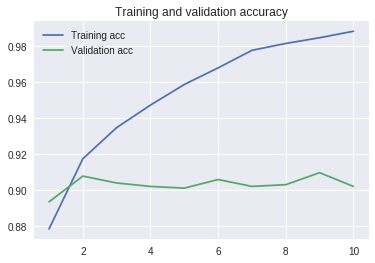

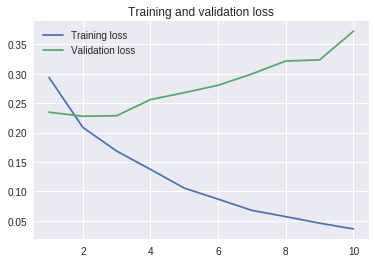

In [33]:
# plotting the results

import matplotlib.pyplot as plt
%matplotlib inline

def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_result(history)

In [35]:
# Building model without pre-trained word embeddings

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(data, labels, epochs=10, batch_size=32, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                320064    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________
Train on 9451 samples, validate on 1051 samples
Epoch 1/10
9451/9451 [==============================] - 5s 573us/step - loss: 0.3082

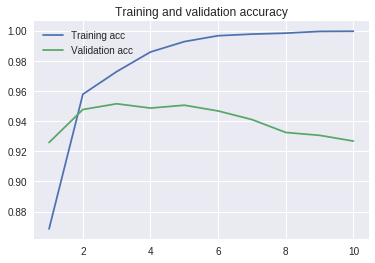

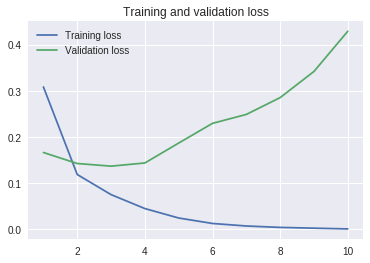

In [37]:
plot_result(history)

### 2. Using Simple RNN layer on top of embedding layer

In [41]:
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(data,labels, epochs=10, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/10
9451/9451 [==============================] - 4s 394us/step - loss: 0.3678 - acc: 0.8351 - val_loss: 0.2602 - val_acc: 0.8934
Epoch 2/10
9451/9451 [==============================] - 3s 321us/step - loss: 0.1480 - acc: 0.9448 - val_loss: 0.1452 - val_acc: 0.9420
Epoch 3/10
9451/9451 [==============================] - 3s 322us/step - loss: 0.0990 - acc: 0.9633 - val_loss: 0.1333 - val_acc: 0.9477
Epoch 4/10
9451/9451 [==============================] - 3s 323us/step - loss: 0.0694 - acc: 0.9758 - val_loss: 0.1307 - val_acc: 0.9515
Epoch 5/10
9451/9451 [==============================] - 3s 321us/step - loss: 0.0485 - acc: 0.9837 - val_loss: 0.1468 - val_acc: 0.9496
Epoch 6/10
9451/9451 [==============================] - 3s 322us/step - loss: 0.0327 - acc: 0.9899 - val_loss: 0.1427 - val_acc: 0.9534
Epoch 7/10
9451/9451 [==============================] - 3s 322us/step - loss: 0.0216 - acc: 0.9934 - val_loss: 0.1623 - val_acc: 0.9496


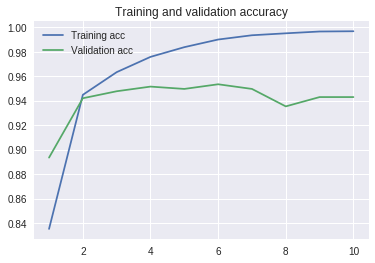

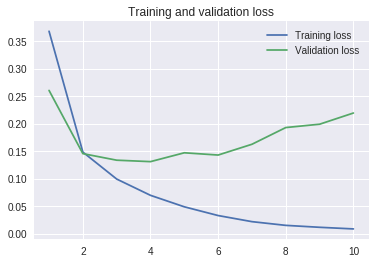

In [44]:
plot_result(history)

### 3. Using LSTM layer on top of the embedding layer

In [0]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [53]:
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(data, labels, epochs=10, batch_size=32, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Train on 9451 samples, validate on 1051 samples
Epoch 1/10
9451/9451 [==============================] - 11s 1ms/step - loss: 0.3223 - acc: 0.8671 - val_loss: 0.1796 - val_acc: 0.9267
Epoch 2/10
9451/9451 [==============================] - 10s 1ms/step - loss: 0.1378 - acc: 0.9495 - val_loss: 0.1462 - val_acc: 0.9420
Epoch 3/10
9451/9451 [==============================] - 10s 1ms/step - loss: 0.103

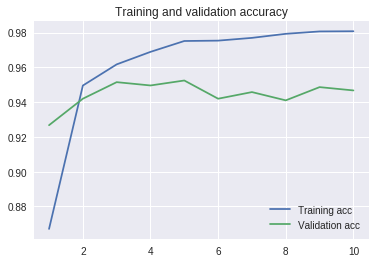

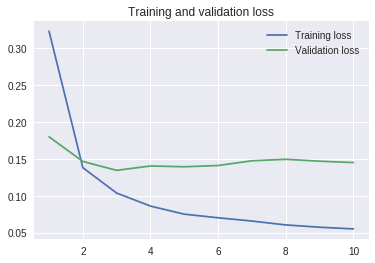

In [54]:
plot_result(history)